In [10]:
import torch
import torch.nn as nn
import scipy.io as sio
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import random

from network import OlshausenField1996Model

from pydeep.preprocessing import ICA, ZCA
import pydeep.misc.io as io
import pydeep.misc.visualization as vis
import argparse

from distortion import contrast_alpha, add_gaussian_noise, blur_beta_pool, blur_beta_resample

In [11]:
imgsize = 9
batch_size = 256
n_units = 100
n_iters = 500
n_samples = n_iters * batch_size
early_stopping = True
nt_max = 1000
device='cpu'

(128256, 81)


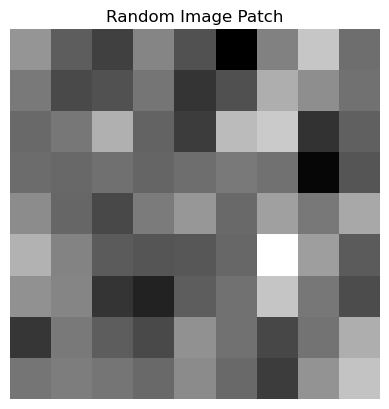

In [12]:
#load base data
#Data from OlshausenField 1996 -> centered but not normalized/random cropped/9x9 patches

data = np.load('.\patches\patches.npy').squeeze().reshape(-1,81)
print(data.shape)

random_idx = random.randint(0, data.shape[0] - 1)
plt.imshow(data[random_idx].reshape(imgsize, imgsize), cmap='gray')
plt.title('Random Image Patch')
plt.axis('off')
plt.show()


In [13]:
#Olshausen
dataloader_olhausen = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
print(len(dataloader_olhausen))

#ZCA whitening for ICA method
zca = ZCA(input_dim=imgsize**2)
zca.train(data=data)

# ZCA projects the whitened data back to the original space, thus does not
# perform a dimensionality reduction but a whitening in the original space
whitened_data = zca.project(data)


501


In [14]:
def train_olshausen(model, dataloader, n_iters, eps, early_stopping=True, nt_max=1000, collect_data_for_ICA=False):
    # Run simulation
    error_list = [] # List to save errors
    if collect_data_for_ICA: #ICA method requires whole batch of data
        ica_data = []
    for n, imgs in tqdm.tqdm(enumerate(dataloader)):

        inputs = imgs
        if collect_data_for_ICA:
            ica_data.append(inputs)
        if inputs.shape[1] != imgsize**2:
            print("Not correct size:", inputs.shape[1], imgsize**2)
            continue  # Skip if image size is not correct

        model.initialize_states() # Reset states
        model.normalize_rows() # Normalize weights
        
        # Input an image patch until latent variables are converged 
        r_tm1 = model.r # set previous r (t minus 1)

        for t in range(nt_max):
            # Update r without update weights 
            error, r = model(inputs, training=False)
            dr = r - r_tm1 

            # Compute norm of r
            dr_norm = torch.norm(dr) / (eps + torch.norm(r_tm1))
            r_tm1 = r # update r_tm1
            
            # Check convergence of r, then update weights
            if dr_norm < eps:
                error, r = model(inputs, training=True)
                break
            
            # If failure to convergence, break and print error
            if t >= nt_max-2: 
                print("Error at patch:", n)
                print(dr_norm)
                break
    
        error_list.append(model.calculate_total_error(error)) # Append errors

        # Print moving average error
        if n % 100 == 99:  
            print("iter: "+str(n+1)+"/"+str(n_iters)+", Moving error:",
                torch.mean(torch.stack(error_list[n-99:n])))
        
        if early_stopping and n >= n_iters:
            break
    
    if collect_data_for_ICA:
        return torch.flatten(torch.stack(ica_data), start_dim=0,end_dim=1).numpy(), error_list
    return error_list


In [15]:
eps = 1e-2 # small value which determines convergence
error_list = [] # List to save errors
olshausen_vanilla = OlshausenField1996Model(num_inputs=imgsize**2, num_units=n_units, batch_size=batch_size, device=device)

error_list = train_olshausen(olshausen_vanilla, dataloader_olhausen, n_iters, eps, early_stopping=early_stopping, nt_max=nt_max)

110it [00:01, 64.71it/s]

iter: 100/500, Moving error: tensor(0.0407)


208it [00:03, 61.40it/s]

iter: 200/500, Moving error: tensor(0.0354)


312it [00:05, 60.81it/s]

iter: 300/500, Moving error: tensor(0.0351)


410it [00:06, 62.56it/s]

iter: 400/500, Moving error: tensor(0.0344)


500it [00:08, 60.49it/s]

iter: 500/500, Moving error: tensor(0.0344)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 117.16it/s]


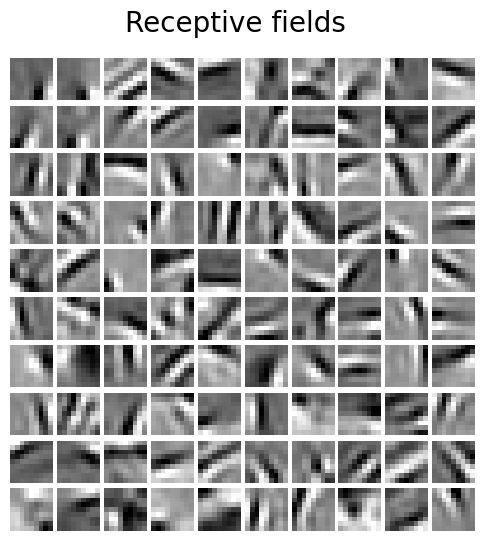

In [16]:
# Plot Receptive fields
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm.tqdm(range(n_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(olshausen_vanilla.Phi[:, i].cpu(), (imgsize, imgsize)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

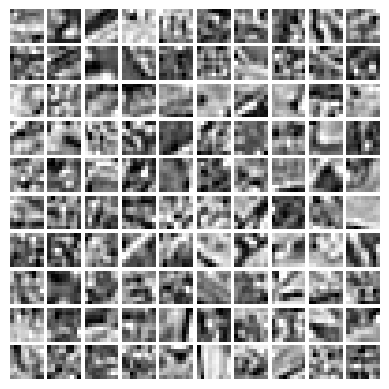

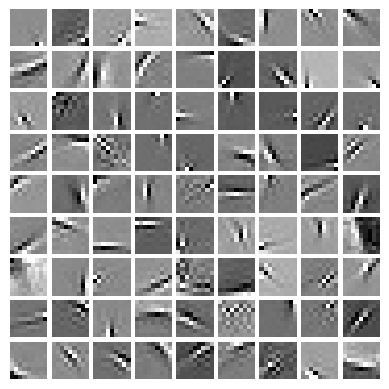

In [17]:
#ICA
ica = ICA(input_dim=imgsize**2)
ica.train(data=whitened_data,
          iterations=100,
          convergence=1.0,
          status=False)

# Show images
images = vis.tile_matrix_rows(matrix=data[0:100].T,
                              tile_width=imgsize,
                              tile_height=imgsize,
                              num_tiles_x=10,
                              num_tiles_y=10,
                              border_size=1,
                              normalized=True)
vis.imshow_matrix(matrix=images,
                  windowtitle='First 100 image patches')

# # Show some whitened images
# images = vis.tile_matrix_rows(matrix=whitened_data[0:100].T,
#                               tile_width=imgsize,
#                               tile_height=imgsize,
#                               num_tiles_x=10,
#                               num_tiles_y=10,
#                               border_size=1,
#                               normalized=True)
# vis.imshow_matrix(matrix=images,
#                   windowtitle='First 100 image patches whitened')

# Show the ICA filters/bases
ica_filters = vis.tile_matrix_rows(matrix=ica.projection_matrix,
                                   tile_width=imgsize,
                                   tile_height=imgsize,
                                   num_tiles_x=imgsize,
                                   num_tiles_y=imgsize,
                                   border_size=1,
                                   normalized=True)
vis.imshow_matrix(matrix=ica_filters,
                  windowtitle='Filters learned by ICA')

vis.show()

#### Now we have olshausen_vanilla and ica trained on orignal data
#### Do inference to distorted data and get the representations

501


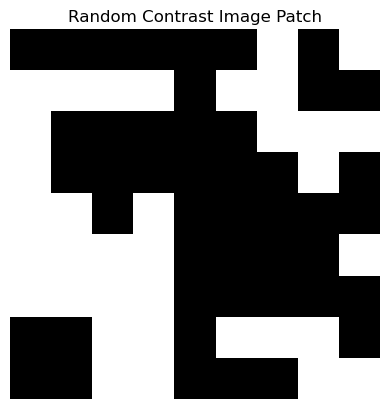

In [18]:
#Contrast param: alpha, 1 for no change, 0 for gray image, 10 for binary image
alpha=10

#Olshausen
transform_contrast = transforms.Compose([
    transforms.ToTensor(),
    contrast_alpha(alpha=alpha),
])

class dataset_contrast(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img = self.patches[idx].reshape(imgsize, imgsize)

        if self.transform is not None:
            img = self.transform(img)
        return img.view(-1)

data_contrast = dataset_contrast(data, transform=transform_contrast)
dataloader_olhausen_contrast = DataLoader(data_contrast, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
print(len(dataloader_olhausen_contrast))

random_idx = random.randint(0, len(data_contrast) - 1)
img = data_contrast[random_idx].numpy().reshape(imgsize, imgsize)
plt.imshow(img, cmap='gray')
plt.title('Random Contrast Image Patch')
plt.axis('off')
plt.show()

501


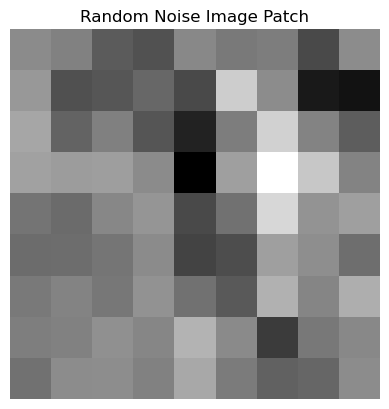

In [19]:
#Noise param: sigma, 0~inf
sigma=0.5 #>=0

#Olshausen
transform_noise = transforms.Compose([
    transforms.ToTensor(),
    add_gaussian_noise(sigma=sigma),
])

class dataset_noise(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img = self.patches[idx].reshape(imgsize, imgsize)

        if self.transform is not None:
            img = self.transform(img)
        return img.view(-1)

data_noise = dataset_noise(data, transform=transform_noise)
dataloader_olhausen_noise = DataLoader(data_noise, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
print(len(dataloader_olhausen_noise))

random_idx = random.randint(0, len(data_noise) - 1)
img = data_noise[random_idx].numpy().reshape(imgsize, imgsize)
plt.imshow(img, cmap='gray')
plt.title('Random Noise Image Patch')
plt.axis('off')
plt.show()

501


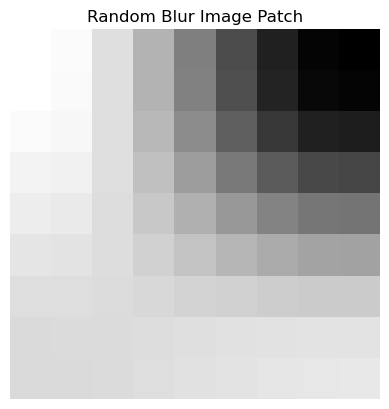

In [20]:
#(pool)Blur param: beta, effect kernel size non-linearly, not that impactful 
#beta<2.2: nochange, 2.2<beta<6.6: mild blur, 6.6<beta<11.1: strong blur, beta>11.1, heavy blur

#(resample)Blur param: beta, 1~3...


beta=3.5 #>=0

#Olshausen
transform_blur = transforms.Compose([
    transforms.ToTensor(),
    #blur_beta_pool(beta=beta),
    blur_beta_resample(beta=beta,mode='bicubic'),
])

class dataset_blur(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img = self.patches[idx].reshape(imgsize, imgsize)

        if self.transform is not None:
            img = self.transform(img)
        return img.view(-1)

data_blur = dataset_blur(data, transform=transform_blur)
dataloader_olhausen_blur = DataLoader(data_blur, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
print(len(dataloader_olhausen_blur))

random_idx = random.randint(0, len(data_blur) - 1)
img = data_blur[random_idx].reshape(imgsize, imgsize)
plt.imshow(img, cmap='gray')
plt.title('Random Blur Image Patch')
plt.axis('off')
plt.show()

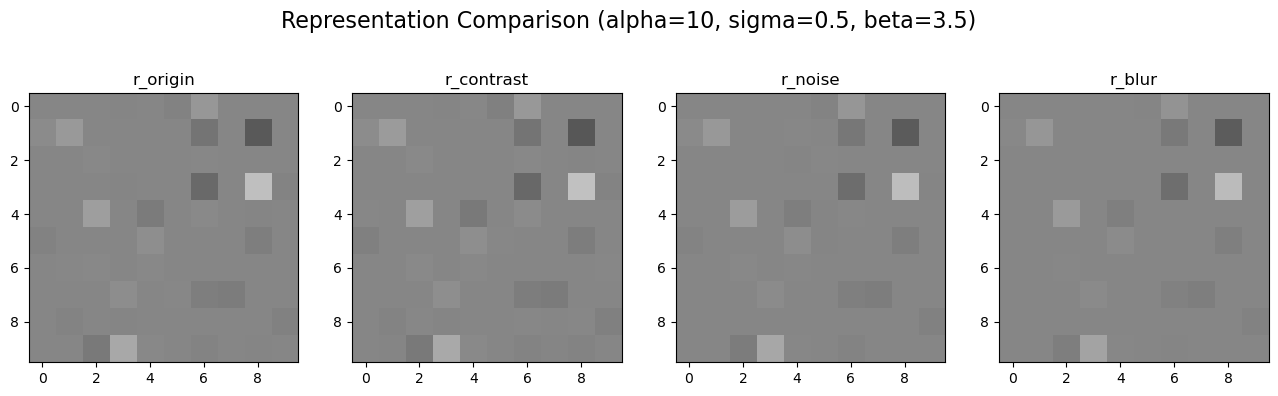

In [21]:
_,r_contrast = olshausen_vanilla(data_contrast[0])
# data_ica_origin = []
# data_ica_contrast = []
# data_ica_noise = []
# data_ica_blur = []

for n,(data_origin,data_contrast,data_noise,data_blur) in enumerate(zip(dataloader_olhausen,dataloader_olhausen_contrast,dataloader_olhausen_noise,dataloader_olhausen_blur)):
    data_ica_origin=data_origin
    data_ica_contrast=data_contrast
    data_ica_noise=data_noise
    data_ica_blur=data_blur
    _,r_contrast = olshausen_vanilla(data_contrast)
    _,r_origin = olshausen_vanilla(data_origin)
    _,r_noise = olshausen_vanilla(data_noise)
    _,r_blur = olshausen_vanilla(data_blur)
    vmin = min(r_origin.min().item(), r_contrast.min().item(), r_noise.min().item(), r_blur.min().item())
    vmax = max(r_origin.max().item(), r_contrast.max().item(), r_noise.max().item(), r_blur.max().item())
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 4, 1)
    plt.title('r_origin')
    plt.imshow(r_origin[0].numpy().reshape(10, 10), vmin=vmin, vmax=vmax)
    plt.subplot(1, 4, 2)
    plt.title('r_contrast')
    plt.imshow(r_contrast[0].numpy().reshape(10, 10), vmin=vmin, vmax=vmax)
    plt.subplot(1, 4, 3)
    plt.title('r_noise')
    plt.imshow(r_noise[0].numpy().reshape(10, 10), vmin=vmin, vmax=vmax)
    plt.subplot(1, 4, 4)
    plt.title('r_blur')
    plt.imshow(r_blur[0].numpy().reshape(10, 10), vmin=vmin, vmax=vmax)
    
    plt.suptitle('Representation Comparison (alpha={}, sigma={}, beta={})'.format(alpha, sigma, beta), fontsize=16)
    plt.subplots_adjust(top=0.98)
    plt.show()
    break


(81,)


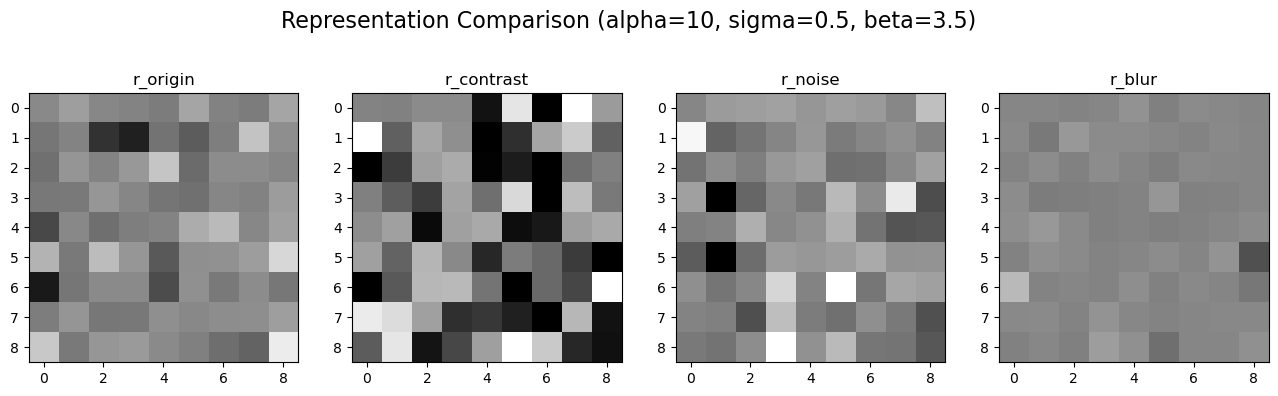

In [22]:
r_ica_origin = ica.unprojection_matrix @ data_ica_origin.numpy().T[:,0]
r_ica_contrast = ica.unprojection_matrix @ data_ica_contrast.numpy().T[:,0]
r_ica_noise = ica.unprojection_matrix @ data_ica_noise.numpy().T[:,0]
r_ica_blur = ica.unprojection_matrix @ data_ica_blur.numpy().T[:,0]
print(r_ica_origin.shape)

vmin = min(r_origin.min().item(), r_contrast.min().item(), r_noise.min().item(), r_blur.min().item())
vmax = max(r_origin.max().item(), r_contrast.max().item(), r_noise.max().item(), r_blur.max().item())
plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
plt.title('r_origin')
plt.imshow(r_ica_origin.reshape(9, 9), vmin=vmin, vmax=vmax)
plt.subplot(1, 4, 2)
plt.title('r_contrast')
plt.imshow(r_ica_contrast.reshape(9, 9), vmin=vmin, vmax=vmax)
plt.subplot(1, 4, 3)
plt.title('r_noise')
plt.imshow(r_ica_noise.reshape(9, 9), vmin=vmin, vmax=vmax)
plt.subplot(1, 4, 4)
plt.title('r_blur')
plt.imshow(r_ica_blur.reshape(9, 9), vmin=vmin, vmax=vmax)

plt.suptitle('Representation Comparison (alpha={}, sigma={}, beta={})'.format(alpha, sigma, beta), fontsize=16)
plt.subplots_adjust(top=0.98)
plt.show()

In [23]:
import torch.nn as nn

class ContrastPredictor(nn.Module):
    def __init__(self, input_dim=100, output_dim=100):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

class NoisePredictor(nn.Module):
    def __init__(self, input_dim=100, output_dim=100):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)
    
class BlurPredictor(nn.Module):
    def __init__(self, input_dim=100, output_dim=100):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)
    

Loss: 0.006534310523420572


5it [00:00, 18.73it/s]

Epoch 0 Batch 0: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


105it [00:05, 20.10it/s]

Epoch 0 Batch 100: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


203it [00:10, 20.54it/s]

Epoch 0 Batch 200: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


302it [00:14, 20.71it/s]

Epoch 0 Batch 300: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


403it [00:20, 18.35it/s]

Epoch 0 Batch 400: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


501it [00:25, 19.82it/s]


Epoch 0 Batch 500: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


2it [00:00, 15.05it/s]

Epoch 1 Batch 0: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


104it [00:05, 19.75it/s]

Epoch 1 Batch 100: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


202it [00:10, 20.10it/s]

Epoch 1 Batch 200: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


305it [00:15, 20.48it/s]

Epoch 1 Batch 300: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


405it [00:20, 20.41it/s]

Epoch 1 Batch 400: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


501it [00:25, 19.61it/s]


Epoch 1 Batch 500: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


2it [00:00, 17.04it/s]

Epoch 2 Batch 0: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


104it [00:05, 20.00it/s]

Epoch 2 Batch 100: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


204it [00:10, 19.73it/s]

Epoch 2 Batch 200: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


305it [00:15, 20.26it/s]

Epoch 2 Batch 300: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


403it [00:20, 20.18it/s]

Epoch 2 Batch 400: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


501it [00:25, 19.89it/s]


Epoch 2 Batch 500: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


2it [00:00, 17.38it/s]

Epoch 3 Batch 0: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


104it [00:05, 20.48it/s]

Epoch 3 Batch 100: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


203it [00:09, 20.61it/s]

Epoch 3 Batch 200: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


305it [00:14, 20.41it/s]

Epoch 3 Batch 300: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


404it [00:19, 21.47it/s]

Epoch 3 Batch 400: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


501it [00:24, 20.68it/s]


Epoch 3 Batch 500: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


2it [00:00, 16.93it/s]

Epoch 4 Batch 0: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


105it [00:05, 21.06it/s]

Epoch 4 Batch 100: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


203it [00:09, 19.92it/s]

Epoch 4 Batch 200: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


305it [00:14, 20.05it/s]

Epoch 4 Batch 300: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


404it [00:19, 20.82it/s]

Epoch 4 Batch 400: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


501it [00:24, 20.61it/s]


Epoch 4 Batch 500: Contrast Loss: 0.00, Noise Loss: 0.00, Blur Loss: 0.00


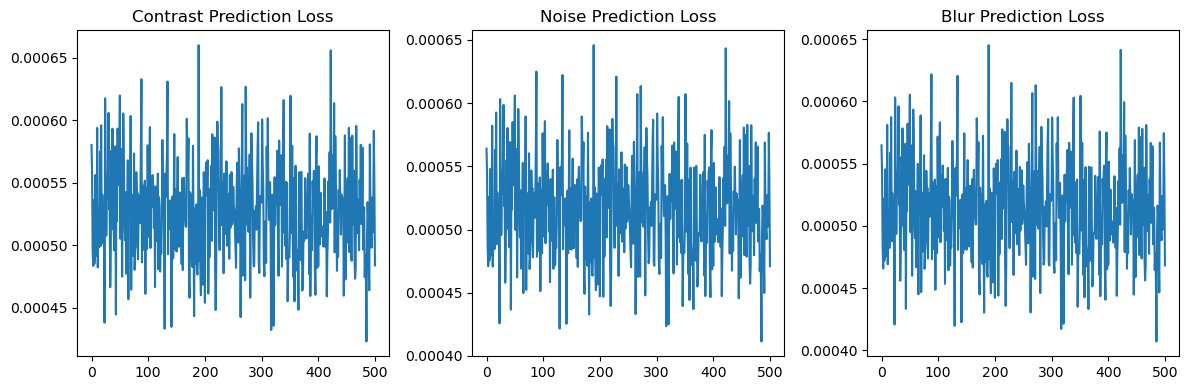

In [30]:
contrast_predictor = ContrastPredictor()
noise_predictor = NoisePredictor()
blur_predictor = BlurPredictor()

loss_fn = nn.MSELoss()

optim_contrast = torch.optim.Adam(contrast_predictor.parameters(), lr=0.0001)
optim_noise = torch.optim.Adam(noise_predictor.parameters(), lr=0.0001)
optim_blur = torch.optim.Adam(blur_predictor.parameters(), lr=0.0001)

#Train
for epochs in range(5):
    for n,(data_origin,data_contrast,data_noise,data_blur) in tqdm.tqdm(enumerate(zip(dataloader_olhausen,dataloader_olhausen_contrast,dataloader_olhausen_noise,dataloader_olhausen_blur))):
        _,r_contrast = olshausen_vanilla(data_contrast)
        _,r_origin = olshausen_vanilla(data_origin)
        _,r_noise = olshausen_vanilla(data_noise)
        _,r_blur = olshausen_vanilla(data_blur)
        
        output_contrast = contrast_predictor(r_contrast)
        output_noise = noise_predictor(r_noise)
        output_blur = blur_predictor(r_blur)

        loss_contrast = loss_fn(output_contrast, r_origin)
        loss_noise = loss_fn(output_noise, r_origin)
        loss_blur = loss_fn(output_blur, r_origin)

        optim_contrast.zero_grad()
        optim_noise.zero_grad()
        optim_blur.zero_grad()

        loss_contrast.backward()
        loss_noise.backward()
        loss_blur.backward()

        optim_contrast.step()
        optim_noise.step()
        optim_blur.step()


        if n%100 == 0:
            print(f'Epoch {epochs} Batch {n}: Contrast Loss: {loss_contrast.item():.2f}, Noise Loss: {loss_noise.item():.2f}, Blur Loss: {loss_blur.item():.2f}')

#Eval
recorder_contrast = []
recorder_noise = []
recorder_blur = []
with torch.no_grad():
    for n,(data_origin,data_contrast,data_noise,data_blur) in enumerate(zip(dataloader_olhausen,dataloader_olhausen_contrast,dataloader_olhausen_noise,dataloader_olhausen_blur)):
        _,r_contrast = olshausen_vanilla(data_contrast)
        _,r_origin = olshausen_vanilla(data_origin)
        _,r_noise = olshausen_vanilla(data_noise)
        _,r_blur = olshausen_vanilla(data_blur)
        
        output_contrast = contrast_predictor(r_contrast)
        output_noise = noise_predictor(r_noise)
        output_blur = blur_predictor(r_blur)

        loss_contrast = loss_fn(output_contrast, r_origin)
        loss_noise = loss_fn(output_noise, r_origin)
        loss_blur = loss_fn(output_blur, r_origin)

        recorder_contrast.append(loss_contrast.item())
        recorder_noise.append(loss_noise.item())
        recorder_blur.append(loss_blur.item())

#Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(recorder_contrast)
plt.title('Contrast Prediction Loss')
plt.subplot(1, 3, 2)
plt.plot(recorder_noise)
plt.title('Noise Prediction Loss')
plt.subplot(1, 3, 3)
plt.plot(recorder_blur)
plt.title('Blur Prediction Loss')
plt.tight_layout()
plt.show()
        
        

In [31]:
#Record the data for ICA
data_ica_contrast = []
data_ica_noise = []
data_ica_blur = []
for n,(data_contrast,data_noise,data_blur) in tqdm.tqdm(enumerate(zip(dataloader_olhausen_contrast,dataloader_olhausen_noise,dataloader_olhausen_blur))):
    data_ica_contrast.append(data_contrast)
    data_ica_noise.append(data_noise)
    data_ica_blur.append(data_blur)

data_ica_contrast = torch.flatten(torch.stack(data_ica_contrast), start_dim=0,end_dim=1).numpy()
data_ica_noise = torch.flatten(torch.stack(data_ica_noise), start_dim=0,end_dim=1).numpy()
data_ica_blur = torch.flatten(torch.stack(data_ica_blur), start_dim=0,end_dim=1).numpy()
print(data_ica_contrast.shape)


501it [00:20, 25.01it/s]

(128256, 81)


In [40]:
#Apply ZCA whitening
#ZCA whitening for ICA method

#reload data
data = np.load('.\patches\patches.npy').squeeze().reshape(-1,81)

zca_origin = ZCA(input_dim=imgsize**2)
zca_origin.train(data=data)
whitened_data_origin = zca_origin.project(data)
print(whitened_data_origin.shape)

zca_contrast = ZCA(input_dim=imgsize**2)
zca_contrast.train(data=data_ica_contrast)
whitened_data_contrast = zca_contrast.project(data_ica_contrast)

zca_noise = ZCA(input_dim=imgsize**2)
zca_noise.train(data=data_ica_noise)
whitened_data_noise = zca_noise.project(data_ica_noise)

zca_blur = ZCA(input_dim=imgsize**2)
zca_blur.train(data=data_ica_blur)
whitened_data_blur = zca_blur.project(data_ica_blur)


(128256, 81)


47it [00:00, 235.49it/s]

Epoch 0 Batch 0: Contrast Loss: 1.35, Noise Loss: 1.29, Blur Loss: 2.11


152it [00:00, 249.74it/s]

Epoch 0 Batch 100: Contrast Loss: 1.26, Noise Loss: 1.18, Blur Loss: 1.83


230it [00:00, 251.65it/s]

Epoch 0 Batch 200: Contrast Loss: 1.28, Noise Loss: 1.31, Blur Loss: 1.82


335it [00:01, 254.85it/s]

Epoch 0 Batch 300: Contrast Loss: 1.21, Noise Loss: 1.17, Blur Loss: 1.94


442it [00:01, 258.05it/s]

Epoch 0 Batch 400: Contrast Loss: 1.14, Noise Loss: 1.09, Blur Loss: 1.61


501it [00:01, 253.42it/s]


Epoch 0 Batch 500: Contrast Loss: 1.15, Noise Loss: 1.20, Blur Loss: 1.78


17it [00:00, 164.00it/s]

Epoch 1 Batch 0: Contrast Loss: 1.15, Noise Loss: 1.13, Blur Loss: 1.53


146it [00:00, 245.38it/s]

Epoch 1 Batch 100: Contrast Loss: 1.11, Noise Loss: 1.12, Blur Loss: 1.39


224it [00:00, 242.18it/s]

Epoch 1 Batch 200: Contrast Loss: 1.09, Noise Loss: 1.02, Blur Loss: 1.51


347it [00:01, 234.24it/s]

Epoch 1 Batch 300: Contrast Loss: 1.07, Noise Loss: 1.01, Blur Loss: 1.51


418it [00:01, 177.78it/s]

Epoch 1 Batch 400: Contrast Loss: 1.07, Noise Loss: 1.02, Blur Loss: 1.76


501it [00:02, 221.21it/s]


Epoch 1 Batch 500: Contrast Loss: 1.07, Noise Loss: 1.04, Blur Loss: 1.48


32it [00:00, 164.14it/s]

Epoch 2 Batch 0: Contrast Loss: 1.06, Noise Loss: 1.09, Blur Loss: 1.46


153it [00:00, 236.94it/s]

Epoch 2 Batch 100: Contrast Loss: 1.01, Noise Loss: 0.96, Blur Loss: 1.75


225it [00:01, 230.57it/s]

Epoch 2 Batch 200: Contrast Loss: 1.02, Noise Loss: 1.00, Blur Loss: 1.86


323it [00:01, 233.79it/s]

Epoch 2 Batch 300: Contrast Loss: 1.03, Noise Loss: 0.95, Blur Loss: 1.53


438it [00:02, 209.22it/s]

Epoch 2 Batch 400: Contrast Loss: 1.02, Noise Loss: 1.08, Blur Loss: 1.49


501it [00:02, 218.42it/s]


Epoch 2 Batch 500: Contrast Loss: 1.00, Noise Loss: 1.20, Blur Loss: 1.60


18it [00:00, 172.36it/s]

Epoch 3 Batch 0: Contrast Loss: 1.01, Noise Loss: 1.11, Blur Loss: 1.52


136it [00:00, 228.73it/s]

Epoch 3 Batch 100: Contrast Loss: 1.01, Noise Loss: 0.98, Blur Loss: 1.51


240it [00:01, 248.48it/s]

Epoch 3 Batch 200: Contrast Loss: 1.00, Noise Loss: 0.91, Blur Loss: 1.82


346it [00:01, 256.10it/s]

Epoch 3 Batch 300: Contrast Loss: 1.01, Noise Loss: 1.10, Blur Loss: 1.56


450it [00:01, 256.31it/s]

Epoch 3 Batch 400: Contrast Loss: 1.01, Noise Loss: 1.02, Blur Loss: 1.58


501it [00:02, 242.29it/s]


Epoch 3 Batch 500: Contrast Loss: 1.03, Noise Loss: 1.10, Blur Loss: 1.52


22it [00:00, 217.62it/s]

Epoch 4 Batch 0: Contrast Loss: 1.00, Noise Loss: 0.91, Blur Loss: 1.44


153it [00:00, 259.05it/s]

Epoch 4 Batch 100: Contrast Loss: 0.99, Noise Loss: 0.89, Blur Loss: 1.40


232it [00:00, 257.01it/s]

Epoch 4 Batch 200: Contrast Loss: 1.02, Noise Loss: 1.06, Blur Loss: 1.39


339it [00:01, 259.06it/s]

Epoch 4 Batch 300: Contrast Loss: 1.00, Noise Loss: 1.13, Blur Loss: 1.54


444it [00:01, 258.33it/s]

Epoch 4 Batch 400: Contrast Loss: 1.00, Noise Loss: 0.99, Blur Loss: 1.45


501it [00:01, 254.97it/s]


Epoch 4 Batch 500: Contrast Loss: 1.01, Noise Loss: 1.01, Blur Loss: 1.35


501it [00:01, 355.33it/s]


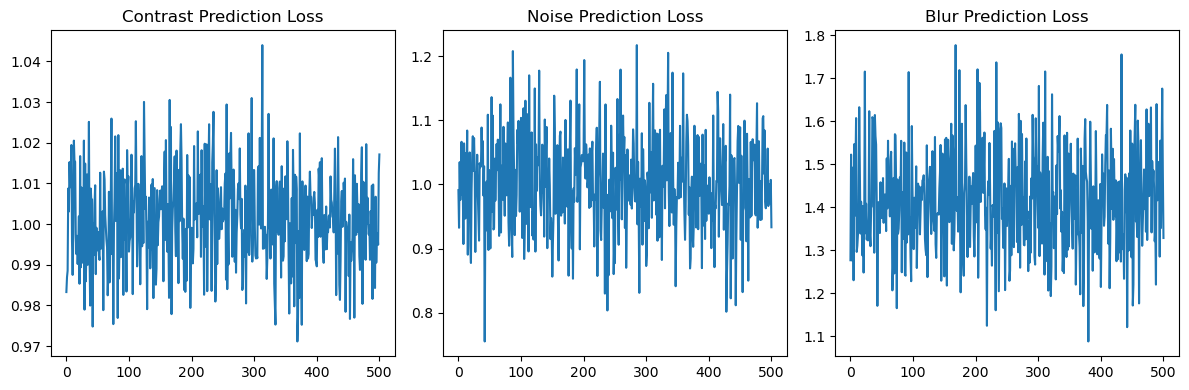

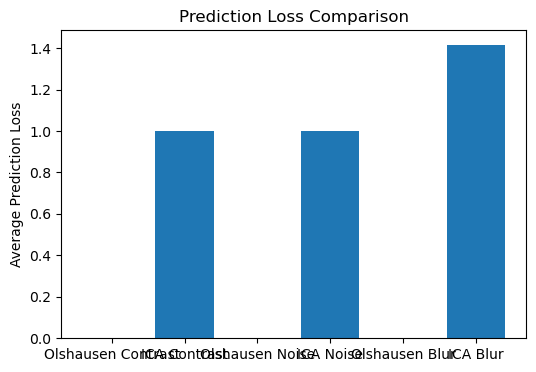

In [42]:
#ICA predictors
contrast_predictor_ica = ContrastPredictor(input_dim=81, output_dim=81)
noise_predictor_ica = NoisePredictor(input_dim=81, output_dim=81)
blur_predictor_ica = BlurPredictor(input_dim=81, output_dim=81)

loss_fn = nn.MSELoss()

optim_contrast_ica = torch.optim.Adam(contrast_predictor_ica.parameters(), lr=0.0001)
optim_noise_ica = torch.optim.Adam(noise_predictor_ica.parameters(), lr=0.0001)
optim_blur_ica = torch.optim.Adam(blur_predictor_ica.parameters(), lr=0.0001)

#Data collection
r_ica_origin = torch.from_numpy((ica.unprojection_matrix @ whitened_data_origin.T).T.astype(np.float32))
r_ica_contrast = torch.from_numpy((ica.unprojection_matrix @ whitened_data_contrast.T).T.astype(np.float32))
r_ica_noise = torch.from_numpy((ica.unprojection_matrix @ whitened_data_noise.T).T.astype(np.float32))
r_ica_blur = torch.from_numpy((ica.unprojection_matrix @ whitened_data_blur.T).T.astype(np.float32))

dataloader_ica_origin = DataLoader(r_ica_origin, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
dataloader_ica_contrast = DataLoader(r_ica_contrast, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
dataloader_ica_noise = DataLoader(r_ica_noise, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
dataloader_ica_blur = DataLoader(r_ica_blur, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)


#Train
for epochs in range(5):
    for n,(data_origin,data_contrast,data_noise,data_blur) in tqdm.tqdm(enumerate(zip(dataloader_ica_origin,dataloader_ica_contrast,dataloader_ica_noise,dataloader_ica_blur))):

        output_contrast = contrast_predictor_ica(data_origin)
        output_noise = noise_predictor_ica(data_origin)
        output_blur = blur_predictor_ica(data_origin)

        loss_contrast = loss_fn(output_contrast, data_contrast)
        loss_noise = loss_fn(output_noise, data_noise)
        loss_blur = loss_fn(output_blur, data_blur)

        optim_contrast_ica.zero_grad()
        optim_noise_ica.zero_grad()
        optim_blur_ica.zero_grad()

        loss_contrast.backward()
        loss_noise.backward()
        loss_blur.backward()

        optim_contrast_ica.step()
        optim_noise_ica.step()
        optim_blur_ica.step()


        if n%100 == 0:
            print(f'Epoch {epochs} Batch {n}: Contrast Loss: {loss_contrast.item():.2f}, Noise Loss: {loss_noise.item():.2f}, Blur Loss: {loss_blur.item():.2f}')

#Eval
recorder_ica_contrast = []
recorder_ica_noise = []
recorder_ica_blur = []
with torch.no_grad():
    for n,(data_origin,data_contrast,data_noise,data_blur) in tqdm.tqdm(enumerate(zip(dataloader_ica_origin,dataloader_ica_contrast,dataloader_ica_noise,dataloader_ica_blur))):
        output_contrast = contrast_predictor_ica(data_origin)
        output_noise = noise_predictor_ica(data_origin)
        output_blur = blur_predictor_ica(data_origin)

        loss_contrast = loss_fn(output_contrast, data_contrast)
        loss_noise = loss_fn(output_noise, data_noise)
        loss_blur = loss_fn(output_blur, data_blur)

        recorder_ica_contrast.append(loss_contrast.item())
        recorder_ica_noise.append(loss_noise.item())
        recorder_ica_blur.append(loss_blur.item())

#Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(recorder_ica_contrast)
plt.title('Contrast Prediction Loss')
plt.subplot(1, 3, 2)
plt.plot(recorder_ica_noise)
plt.title('Noise Prediction Loss')
plt.subplot(1, 3, 3)
plt.plot(recorder_ica_blur)
plt.title('Blur Prediction Loss')
plt.tight_layout()
plt.show()


        
        

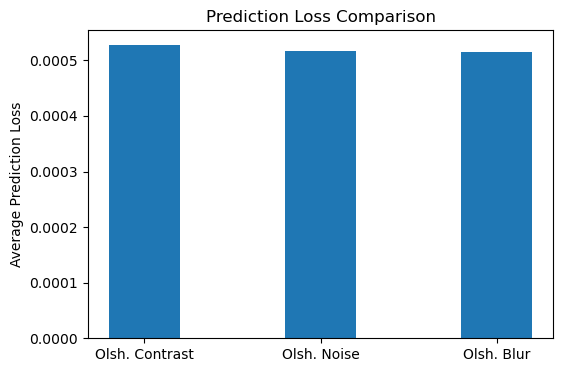

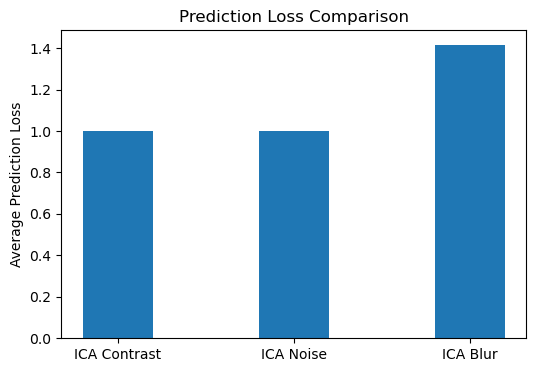

In [45]:
plt.figure(figsize=(6, 4))
plt.bar(['Olsh. Contrast', 'Olsh. Noise', 'Olsh. Blur'],
        [np.mean(recorder_contrast),
         np.mean(recorder_noise),
         np.mean(recorder_blur), ],
         width=0.4)
plt.ylabel('Average Prediction Loss')
plt.title('Prediction Loss Comparison')
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['ICA Contrast', 'ICA Noise', 'ICA Blur'],
        [np.mean(recorder_ica_contrast),
         np.mean(recorder_ica_noise),
         np.mean(recorder_ica_blur)],
         width=0.4)
plt.ylabel('Average Prediction Loss')
plt.title('Prediction Loss Comparison')
plt.show()